### Import statements

In [1]:
import fastai
print(fastai.__version__)

1.0.28


In [2]:
from fastai import *
from fastai.vision import *
from fastai.vision.image import *

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

import os
import cv2

from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight

import math
import subprocess
from operator import itemgetter

In [3]:
np.random.seed(42)

In [4]:
path = Path('data')

In [5]:
name_label_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

In [6]:
train_df = pd.read_csv(path / 'train.csv')
train_df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [7]:
RESNET_ENCODERS = {
    34: torchvision.models.resnet34,
    50: torchvision.models.resnet50,
    101: torchvision.models.resnet101,
    152: torchvision.models.resnet152,
}

In [8]:
class Resnet4Channel(nn.Module):
    
    def __init__(self, encoder_depth=34, pretrained=True, num_classes=28):
        super().__init__()
        encoder = RESNET_ENCODERS[encoder_depth](pretrained=pretrained)
        w = encoder.conv1.weight
        self.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv1.weight = nn.Parameter(torch.cat((w, torch.zeros(64, 1, 7, 7)), dim=1))
        self.bn1 = encoder.bn1
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        
        self.layer1 = encoder.layer1
        self.layer2 = encoder.layer2
        self.layer3 = encoder.layer3
        self.layer4 = encoder.layer4
        
        self.avgpool = encoder.avgpool
        self.fc = nn.Linear(512 * (1 if encoder_depth == 34 else 4), num_classes)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [9]:
def open_4_channel(fname):
    fname = str(fname)
    if fname.endswith(".png"):
        fname = fname[:-4]
        
    colors = ['red', 'green', 'blue', 'yellow']
    flags = cv2.IMREAD_GRAYSCALE
    
    img = [cv2.imread(fname + '_' + color + '.png', flags).astype(np.float32) / 255 for color in colors]
    
    x = np.stack(img, axis=-1)
    
    return Image(pil2tensor(x, np.float32).float())

In [10]:
src = (ImageItemList.from_csv(path, 'train.csv', folder='train', suffix='.png')
      .random_split_by_pct(0.2)
      .label_from_df(sep=' ', classes=[str(i) for i in range(28)]))

In [11]:
src.train.x.open = open_4_channel
src.train.x.create_func = open_4_channel

In [12]:
src.valid.x.open = open_4_channel
src.valid.x.create_func = open_4_channel

In [13]:
test_ids = list(sorted(set(fname.split('_')[0] for fname in os.listdir(path / 'test'))))

In [14]:
test_fnames = [path/'test'/test_id for test_id in test_ids]

In [15]:
test_fnames[:5]

[PosixPath('data/test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('data/test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('data/test/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0'),
 PosixPath('data/test/0008baca-bad7-11e8-b2b9-ac1f6b6435d0'),
 PosixPath('data/test/000cce7e-bad4-11e8-b2b8-ac1f6b6435d0')]

In [16]:
src.add_test(test_fnames, label='0');

In [17]:
src.test.x.open = open_4_channel
src.test.x.create_func = open_4_channel

In [18]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

In [19]:
trn_tfms, _ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1, max_lighting=0.05, max_warp=0.)

In [20]:
data = (src.transform((trn_tfms, _), size=384).databunch(bs=32).normalize(protein_stats))

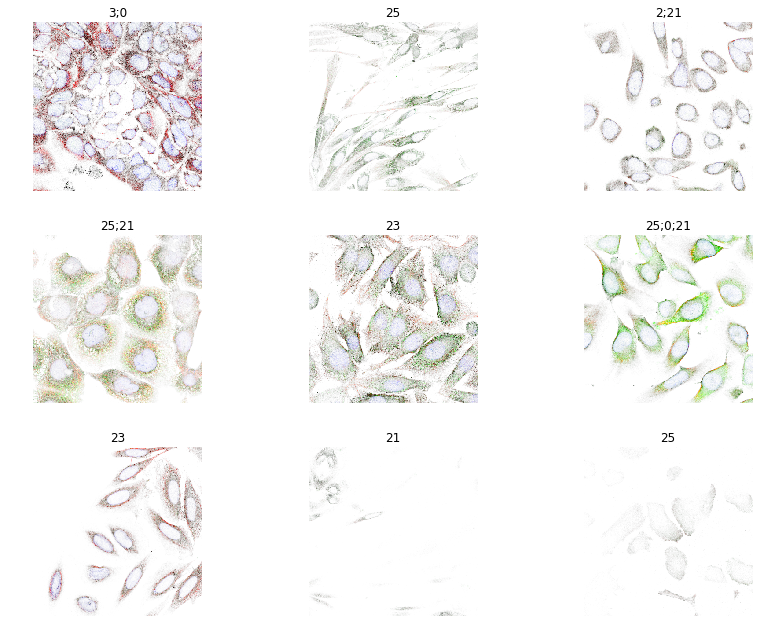

In [21]:
data.show_batch(rows=3, figsize=(12,9))

In [22]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = (self.alpha * (1 - pt) ** self.gamma) * BCE_loss
#         print("BCE loss:", BCE_loss, " F_loss:", F_loss)
        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [23]:
def resnet50(pretrained):
    return Resnet4Channel(encoder_depth=50)

In [24]:
def _resnet_split(m): return (m[0][6],m[1])

In [25]:
f1_score = partial(fbeta, thresh=0.2, beta=1)

In [26]:
# learn = create_cnn(
#     data,
#     resnet50,
#     cut=-2,
#     split_on=_resnet_split,
#     loss_func=FocalLoss(),
#     path=path,    
#     metrics=[f1_score], 
# )

In [27]:
# learn.lr_find()
# learn.recorder.plot()

In [28]:
class FocalLoss2(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.sum(dim=1).mean()

In [29]:
learn = create_cnn(
    data,
    resnet50,
    cut=-2,

    split_on=_resnet_split,
    loss_func=FocalLoss2(),
    path=path,    
    metrics=[f1_score], 
)

In [27]:
learn.fit_one_cycle(4, 1e-2)

Total time: 28:47
epoch  train_loss  valid_loss  fbeta   
1      1.421125    1.105636    0.290759  (07:25)
2      1.021199    1.074275    0.304466  (07:07)
3      0.892029    0.841615    0.346947  (07:06)
4      0.827135    0.793152    0.381595  (07:08)



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


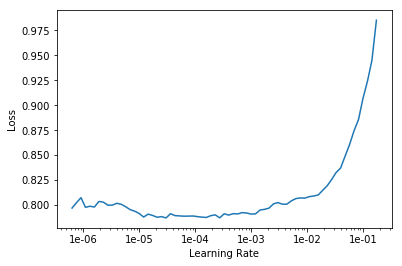

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(6, 5e-4)

Total time: 42:54
epoch  train_loss  valid_loss  fbeta   
1      0.798967    0.785881    0.388052  (07:06)
2      0.792394    0.783462    0.390737  (07:04)
3      0.786139    0.770776    0.399994  (07:09)
4      0.772392    0.762248    0.404944  (07:11)
5      0.753461    0.758804    0.406168  (07:11)
6      0.753316    0.757927    0.407684  (07:10)



In [30]:
learn.fit_one_cycle(6, 5e-4)

Total time: 43:02
epoch  train_loss  valid_loss  fbeta   
1      0.752945    0.757462    0.409620  (07:09)
2      0.752943    0.753785    0.404325  (07:10)
3      0.744743    0.753847    0.414789  (07:09)
4      0.743492    0.744883    0.418952  (07:10)
5      0.731836    0.739555    0.421092  (07:10)
6      0.735682    0.740930    0.427145  (07:11)



In [31]:
learn.fit_one_cycle(10, 1e-4)

Total time: 1:11:54
epoch  train_loss  valid_loss  fbeta   
1      0.723143    0.739536    0.420984  (07:09)
2      0.717652    0.739101    0.423286  (07:11)
3      0.732934    0.737880    0.421559  (07:10)
4      0.721404    0.736607    0.421974  (07:10)
5      0.720639    0.737048    0.427760  (07:11)
6      0.719972    0.733825    0.424767  (07:11)
7      0.715124    0.735028    0.429533  (07:11)
8      0.712460    0.733363    0.422804  (07:12)
9      0.708084    0.732699    0.423319  (07:12)
10     0.713599    0.732392    0.423684  (07:12)



In [33]:
learn.save("freeze-224")

In [30]:
_ = learn.load("freeze-224")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


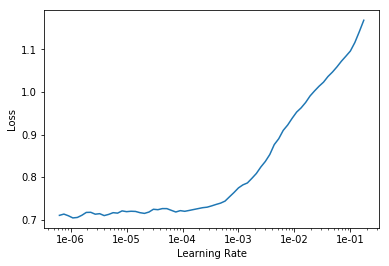

In [31]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(16, slice(1e-7, 1e-4))

Total time: 2:31:33
epoch  train_loss  valid_loss  fbeta   
1      0.724999    0.734422    0.434234  (09:43)
2      0.714912    0.732488    0.427373  (09:31)
3      0.726738    0.730633    0.427972  (09:30)
4      0.713605    0.729389    0.432285  (09:29)
5      0.717748    0.726492    0.430669  (09:28)
6      0.705153    0.723684    0.432612  (09:26)
7      0.701239    0.722143    0.440689  (09:28)
8      0.701717    0.719908    0.437601  (09:25)
9      0.696431    0.718842    0.444879  (09:26)
10     0.697710    0.717034    0.441309  (09:25)
11     0.688000    0.714239    0.437990  (09:25)
12     0.694529    0.714419    0.440483  (09:25)
13     0.684834    0.714790    0.442630  (09:24)
14     0.682058    0.714171    0.449386  (09:26)
15     0.686492    0.714548    0.440064  (09:26)
16     0.674797    0.713295    0.437893  (09:26)



In [33]:
learn.fit_one_cycle(10, slice(1e-8, 1e-5))

Total time: 1:34:33
epoch  train_loss  valid_loss  fbeta   
1      0.681171    0.712953    0.444712  (09:27)
2      0.689312    0.713936    0.444487  (09:28)
3      0.679812    0.712616    0.443086  (09:28)
4      0.685292    0.712381    0.441862  (09:27)
5      0.679401    0.712188    0.445903  (09:27)
6      0.688011    0.712492    0.445327  (09:27)
7      0.682469    0.711764    0.443232  (09:26)
8      0.681156    0.711875    0.444704  (09:26)
9      0.687307    0.712902    0.446302  (09:27)
10     0.686919    0.712313    0.440260  (09:26)



In [34]:
learn.save("224-unfreeze")

In [30]:
_ = learn.load("224-unfreeze")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


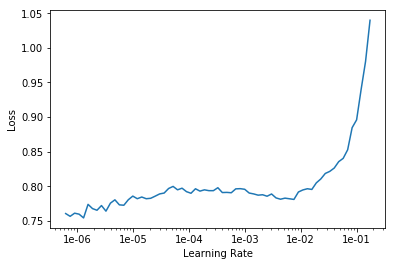

In [31]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(10, 1e-3)

Total time: 3:10:21
epoch  train_loss  valid_loss  fbeta   
1      0.721827    0.672195    0.456403  (19:23)
2      0.721661    0.669007    0.478795  (18:59)
3      0.720632    0.675769    0.447786  (19:00)
4      0.681496    0.679520    0.479723  (18:58)
5      0.694283    0.653048    0.482176  (18:57)
6      0.654313    0.640394    0.489653  (19:00)
7      0.660593    0.622550    0.495259  (19:02)
8      0.626767    0.614395    0.500658  (18:58)
9      0.619326    0.610140    0.502838  (18:59)
10     0.604111    0.611299    0.510765  (19:00)



In [34]:
learn.fit_one_cycle(10, 1e-3)

Total time: 3:09:54
epoch  train_loss  valid_loss  fbeta   
1      0.628718    0.618476    0.513589  (18:56)
2      0.641034    0.619897    0.486767  (18:58)
3      0.669643    0.662908    0.496112  (18:59)
4      0.658600    0.642661    0.488981  (18:59)
5      0.649487    0.628376    0.485786  (18:58)
6      0.622724    0.624943    0.521210  (18:59)
7      0.612086    0.610081    0.506526  (18:59)
8      0.599531    0.604396    0.527465  (19:00)
9      0.571368    0.596460    0.522144  (18:58)
10     0.554929    0.601113    0.527543  (19:00)



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


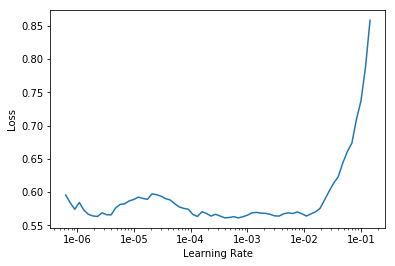

In [36]:
learn.lr_find()
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(10, 1e-4)

Total time: 3:09:55
epoch  train_loss  valid_loss  fbeta   
1      0.587340    0.599543    0.526807  (18:58)
2      0.595435    0.594029    0.526083  (18:59)
3      0.599304    0.598028    0.540702  (19:00)
4      0.589245    0.596406    0.532212  (19:00)
5      0.581565    0.596806    0.534849  (18:58)
6      0.584009    0.599944    0.544993  (18:58)
7      0.549242    0.596322    0.532732  (18:58)
8      0.583651    0.600072    0.550867  (18:59)
9      0.563969    0.593843    0.537223  (19:00)
10     0.555737    0.595481    0.540521  (19:00)



In [38]:
learn.save("freeze-384")

In [30]:
_ = learn.load("freeze-384")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


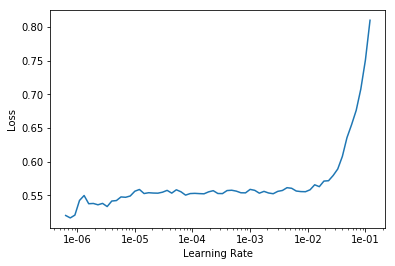

In [39]:
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(15, 5e-6)

Total time: 4:43:07
epoch  train_loss  valid_loss  fbeta   
1      0.566045    0.598493    0.536592  (19:21)
2      0.550814    0.594681    0.539551  (18:48)
3      0.552411    0.596314    0.538082  (18:48)
4      0.557122    0.597094    0.538452  (18:47)
5      0.560927    0.597635    0.546554  (18:48)
6      0.554757    0.595068    0.541741  (18:50)
7      0.574589    0.593254    0.533234  (18:50)
8      0.564290    0.597141    0.542921  (18:48)
9      0.571279    0.594088    0.533618  (18:51)
10     0.563177    0.596262    0.546779  (18:50)
11     0.566050    0.593656    0.535131  (18:51)
12     0.550699    0.594864    0.543594  (18:51)
13     0.555844    0.594045    0.538227  (18:52)
14     0.574178    0.595002    0.538719  (18:52)
15     0.559509    0.594720    0.538739  (18:52)



In [32]:
learn.save("freeze-384-2")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


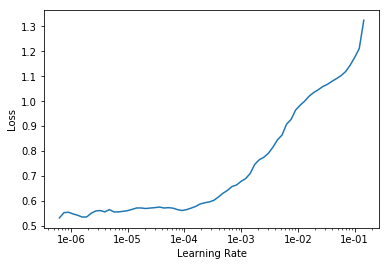

In [33]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(10, slice(1e-8, 5e-6))

Total time: 4:06:44
epoch  train_loss  valid_loss  fbeta   
1      0.556636    0.592077    0.534267  (24:43)
2      0.571523    0.596938    0.539679  (24:38)
3      0.554232    0.596137    0.536667  (24:40)
4      0.562855    0.596769    0.540990  (24:40)
5      0.558696    0.593674    0.539754  (24:41)
6      0.562939    0.592202    0.545799  (24:40)
7      0.570003    0.594096    0.536478  (24:40)
8      0.558884    0.592361    0.540284  (24:39)
9      0.538937    0.591944    0.539931  (24:40)
10     0.550059    0.594485    0.544747  (24:40)



In [35]:
learn.save("unfreeze-384")

In [40]:
preds,_ = learn.get_preds(DatasetType.Test)

pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > 0.0)[0]])) for row in np.array(preds)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
# df.to_csv(path/'protein_predictions_datablocks.csv', header=True, index=False)
df.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,


In [41]:
df.to_csv(path / 'focal-loss-submission-384-tmp.csv', header=True, index=False)

In [45]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

preds, y = learn.TTA(ds_type=DatasetType.Test)
preds = np.stack(preds, axis=-1)
preds = sigmoid_np(preds)
pred = preds.max(axis=-1)

Total time: 34:16



In [46]:
def F1_soft(preds, targs, th=0.5, d=50.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0 * (preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = 0.5*np.ones(28)
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p